# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [1]:
# !pip install category_encoders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn.svm import SVC
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("telecom_churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Сгруппируем признаки по типам данных: 

Это пригодится в их обработке 

In [4]:
num_cols = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')].tolist()
cat_cols = df.columns[df.dtypes == 'object']

### Бинарные признаки и таргет сразу закодируем через 1 и 0

In [73]:
df['Churn'] = (df['Churn']).astype(int)
df['International plan'] = (df['International plan'] == 'Yes').astype(int)
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype(int)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [74]:
df.apply(lambda x: x.unique().shape)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,51,212,3,2,2,46,1667,119,1667,1611,123,1440,1591,120,933,162,21,162,10,2


In [75]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Кодируем небинарный категориальный признак: 

In [76]:
te = TargetEncoder(cols=['State'], smoothing=2.0) #кодируем небинарный категориальный признак

X_train = te.fit_transform(X_train, y_train)
X_test = te.transform(X_test, y_test)

### Масштабируем числовые признаки: 

In [77]:
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

### A: ~~регрессируем~~ применяем логистическую регрессию

In [78]:
params = {'C': np.arange(0.9, 7, 0.4)}
gcv = GridSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l2'),
                  param_grid=params,
                  scoring='f1',
                  cv=5)
gcv.fit(X_train, y_train)
print(gcv.best_params_, f'best estimator: {gcv.best_estimator_}', f'best f1-score: {gcv.best_score_}',sep='\n')
logreg1 = gcv.best_estimator_

{'C': 6.9}
best estimator: LogisticRegression(C=6.9, max_iter=5000)
best f1-score: 0.32711893115562846


In [79]:
logreg1.fit(X_train, y_train)
y_pred_test = logreg1.predict(X_test)
y_pred_train = logreg1.predict(X_train)

tpr_train, fpr_train, thresh = roc_curve(y_train, logreg1.predict_proba(X_train)[:, 0])
tpr_test, fpr_test, thresh = roc_curve(y_test, logreg1.predict_proba(X_test)[:, 0])
print('На train:',
     f'f1_score:{f1_score(y_train, y_pred_train)}',
     f'ROC-AUC:{auc(fpr_train, tpr_train)}',
     f'accuracy:{accuracy_score(y_train, y_pred_train)}',
     'На test:',
     f'f1_score:{f1_score(y_test, y_pred_test)}', 
     f'ROC-AUC:{auc(fpr_test, tpr_test)}',
     f'accuracy:{accuracy_score(y_test, y_pred_test)}', sep='\n')

На train:
f1_score:0.35661764705882354
ROC-AUC:0.8362429061484572
accuracy:0.8687171792948237
На test:
f1_score:0.2741935483870968
ROC-AUC:0.810415899889584
accuracy:0.8650674662668666


In [12]:
1 - y_train.mean(), 1 - y_test.mean()

(0.854463615903976, 0.8575712143928036)

Алгоритм немного переобучен, если судить по более низким значениям F-1 показателя на тесте. Однако важнее то, что качество модели в целом оставляет желать лучшего:
* получаем низкие значения F-1 score - алгоритм плохо различает классы 
* accuracy равно как на обучающей, так и на тестовой выборке, слабо отличается от accuracy от константного прогноза $\alpha(x_i) = 0$

### В: Метод опорных векторов 

In [13]:
gcv2 = GridSearchCV(estimator=SVC(kernel='linear', probability=True),
                  param_grid=params,
                  scoring='f1',
                  cv=5)
gcv2.fit(X_train, y_train)
print(gcv2.best_params_,  f'best estimator: {gcv2.best_estimator_}', f'best f1-score: {gcv2.best_score_}', sep='\n')
svm1 = gcv2.best_estimator_

{'C': 0.9}
best estimator: SVC(C=0.9, kernel='linear', probability=True)
best f1-score: 0.0


In [14]:
svm1.fit(X_train, y_train)
y_pred_test = svm1.predict(X_test)
y_pred_train = svm1.predict(X_train)

tpr_train, fpr_train, thresh = roc_curve(y_train, svm1.predict_proba(X_train)[:, 0])
tpr_test, fpr_test, thresh = roc_curve(y_test, svm1.predict_proba(X_test)[:, 0])
print('На train:',
     f'f1_score:{f1_score(y_train, y_pred_train)}',
     f'ROC-AUC:{auc(fpr_train, tpr_train)}',
     f'accuracy:{accuracy_score(y_train, y_pred_train)}',
     'На test:',
     f'f1_score:{f1_score(y_test, y_pred_test)}', 
     f'ROC-AUC:{auc(fpr_test, tpr_test)}',
     f'accuracy:{accuracy_score(y_test, y_pred_test)}', sep='\n')

На train:
f1_score:0.0
ROC-AUC:0.8113126001285265
accuracy:0.854463615903976
На test:
f1_score:0.0
ROC-AUC:0.7689363268310638
accuracy:0.8575712143928036


SVM дает константный прогноз.

Что же, модель не просто недообучилась, а решила не обучаться вовсе

### C, D: Корреляции и полиномиальные признаки

Прежде чем создавать новые признаки, попробуем исключить те, 
* что слишком слабо коррелируют с объясняемой переменной (добавление новых признаков, не имеющих линейной связи с $y$, может лишь усугубить ситуацию) 
* что сильно коррелируют друг с другом (мультиколлинеарность до добра не доводит) 

In [15]:
import seaborn as sns

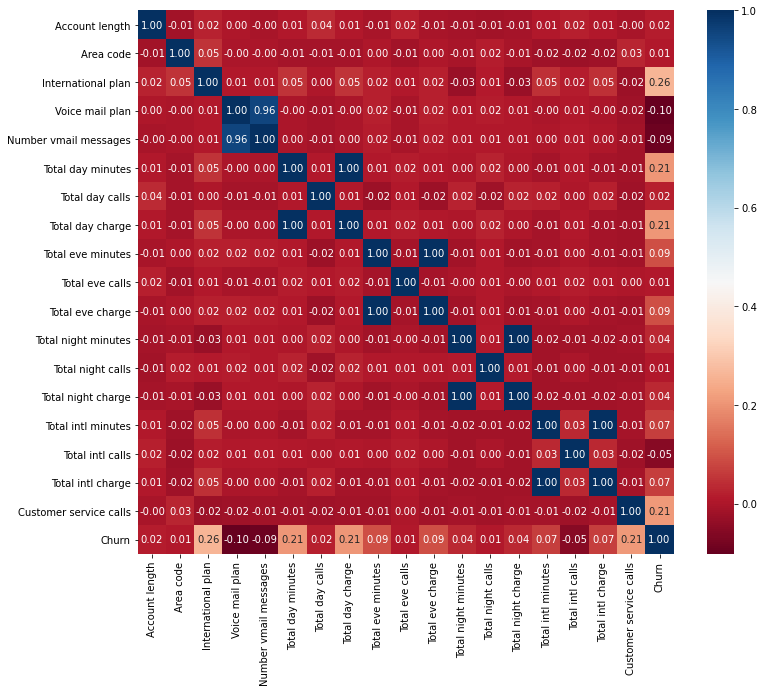

In [16]:
corr = df.corr()
fig, ax = plt.subplots(figsize = (12, 10))
ax = sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu', )

In [17]:
corr_table = corr.drop('Churn', axis=0).reset_index().drop('Churn', axis=1)
d = {}
for col in corr_table.columns[1:]:
    val = corr_table.loc[(corr_table[col].abs() > 0.05) & (corr_table['index'] != col)]['index'].values
    if val.shape[0] > 0:
        d[col] = val
d

{'Voice mail plan': array(['Number vmail messages'], dtype=object),
 'Number vmail messages': array(['Voice mail plan'], dtype=object),
 'Total day minutes': array(['Total day charge'], dtype=object),
 'Total day charge': array(['Total day minutes'], dtype=object),
 'Total eve minutes': array(['Total eve charge'], dtype=object),
 'Total eve charge': array(['Total eve minutes'], dtype=object),
 'Total night minutes': array(['Total night charge'], dtype=object),
 'Total night charge': array(['Total night minutes'], dtype=object),
 'Total intl minutes': array(['Total intl charge'], dtype=object),
 'Total intl charge': array(['Total intl minutes'], dtype=object)}

In [18]:
corr.Churn.abs() > 0.07

Account length            False
Area code                 False
International plan         True
Voice mail plan            True
Number vmail messages      True
Total day minutes          True
Total day calls           False
Total day charge           True
Total eve minutes          True
Total eve calls           False
Total eve charge           True
Total night minutes       False
Total night calls         False
Total night charge        False
Total intl minutes        False
Total intl calls          False
Total intl charge         False
Customer service calls     True
Churn                      True
Name: Churn, dtype: bool

In [19]:
np.corrcoef(X_test['State'], y_test)[1, 0]

0.08666188856292753

### Итого:
1. Выбираем признаки, линейно не связанные между собой (ну, почти) и коррелирующие с объяснеямой переменной
2. Проводим преобразования данных 
3. Запускаем снова поиск по сетке

In [80]:
X = df[['International plan', 'Voice mail plan', 'Total day minutes', 'Customer service calls', 'Total eve charge']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

nums = ['Total day minutes', 'Customer service calls', 'Total eve charge']
sc = StandardScaler()
X_train[nums] = sc.fit_transform(X_train[nums])
X_test[nums] = sc.transform(X_test[nums])

<ipython-input-80-f28a41db3547>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[nums] = sc.fit_transform(X_train[nums])
C:\Users\ruattar\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-80-f28a41db3547>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [81]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [82]:
X_train.shape

(2666, 55)

### Снова лог рег

In [83]:
params = {'C': np.arange(0.1, 4, 0.4)}
gcv = GridSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l2'),
                  param_grid=params,
                  scoring='f1',
                  cv=5)
gcv.fit(X_train, y_train)
print(gcv.best_params_, f'best estimator: {gcv.best_estimator_}', f'best f1-score: {gcv.best_score_}',sep='\n')
logreg2 = gcv.best_estimator_

logreg2.fit(X_train, y_train)
y_pred_test = logreg2.predict(X_test)
y_pred_train = logreg2.predict(X_train)

tpr_train, fpr_train, thresh = roc_curve(y_train, logreg2.predict_proba(X_train)[:, 0])
tpr_test, fpr_test, thresh = roc_curve(y_test, logreg2.predict_proba(X_test)[:, 0])
print('На train:',
     f'f1_score: {f1_score(y_train, y_pred_train)}',
     f'ROC-AUC: {auc(fpr_train, tpr_train)}',
     f'accuracy: {accuracy_score(y_train, y_pred_train)}',
     'На test:',
     f'f1_score: {f1_score(y_test, y_pred_test)}', 
     f'ROC-AUC: {auc(fpr_test, tpr_test)}',
     f'accuracy: {accuracy_score(y_test, y_pred_test)}', sep='\n')

{'C': 2.1}
best estimator: LogisticRegression(C=2.1, max_iter=5000)
best f1-score: 0.6422174685642996
На train:
f1_score: 0.6857142857142857
ROC-AUC: 0.9141315858548374
accuracy: 0.9216054013503376
На test:
f1_score: 0.6341463414634145
ROC-AUC: 0.8881302907618698
accuracy: 0.9100449775112444


### Снова SVM 

In [84]:
gcv2 = GridSearchCV(estimator=SVC(kernel='linear', probability=True),
                  param_grid=params,
                  scoring='f1',
                  cv=5)
gcv2.fit(X_train, y_train)
print(gcv2.best_params_,  f'best estimator: {gcv2.best_estimator_}', f'best f1-score: {gcv2.best_score_}', sep='\n')
svm2 = gcv2.best_estimator_

svm2.fit(X_train, y_train)
y_pred_test = svm2.predict(X_test)
y_pred_train = svm2.predict(X_train)

tpr_train, fpr_train, thresh = roc_curve(y_train, svm2.predict_proba(X_train)[:, 0])
tpr_test, fpr_test, thresh = roc_curve(y_test, svm2.predict_proba(X_test)[:, 0])
print('На train:',
     f'f1_score:{f1_score(y_train, y_pred_train)}',
     f'ROC-AUC:{auc(fpr_train, tpr_train)}',
     f'accuracy:{accuracy_score(y_train, y_pred_train)}',
     'На test:',
     f'f1_score:{f1_score(y_test, y_pred_test)}', 
     f'ROC-AUC:{auc(fpr_test, tpr_test)}',
     f'accuracy:{accuracy_score(y_test, y_pred_test)}', sep='\n')

{'C': 1.7000000000000002}
best estimator: SVC(C=1.7000000000000002, kernel='linear', probability=True)
best f1-score: 0.6256367036177354
На train:
f1_score:0.6697530864197532
ROC-AUC:0.9081849696333373
accuracy:0.9197299324831207
На test:
f1_score:0.6329113924050633
ROC-AUC:0.8781560544718441
accuracy:0.9130434782608695


### E. Мини-отчет о проведенной работе. 

Для этого ответьте на вопросы: 

a) какой классификатор дал наилучший результат? 

**Ответ**: Лучший результат дала логит-модель `LogisticRegression(C=2.1, max_iter=5000)`. Чуть лучше чем svm на тесте по кросс-валидации на обучающей. 

чему равны значения метрик accuracy, f1-score и ROC-AUC? 

**Ответ**: На тестовой подвыборке **f1_score = 0.63, ROC-AUC = 0.89, accuracy = 0.91**
F1-score почти в два раза больше первоначального, а значение accuracy уже заметно отличается от константного предсказания. 

b) какие новые признаки вы добавили и какие признаки удалили?

**Ответ**:
Удалил все признаки кроме `'International plan', 'Voice mail plan', 'Total day minutes', 'Customer service calls', 'Total eve charge'`. Добавил полиномиальные признаки третьей степени от них. 

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

**Ответ**:Проблему "недообучения", кажется, удалось преодолеть: получили модель заметно лучшего качества по сравнению с пунктами A и В по всем метрикам; кроме того, как было сказано ранее, доля верных ответов больше на 6 процентных пунктов, чем при константном прогнозе "все нули". 

Переобучения также избежали: f1-score на тесте сопоставим со значением данной метрики, посчитанной по кросс-валидации на обучающей выборке (разница порядка 1.5%) 

## Часть 2. Оценка качества моделей классификации (5 баллов).

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [5]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [6]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [7]:
df.target.value_counts(normalize=True)

0    0.554427
1    0.445573
Name: target, dtype: float64

Доли близки к половине, выборка сбалансирована по классам

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [8]:
#your code here
from sklearn.metrics import accuracy_score, precision_score, recall_score
for i in [1, 2, 3]:
    col = f'pred{i}_classes'
    print(f'accuracy {i}-го алгоритма: {accuracy_score(df.target, df[col])}')

accuracy 1-го алгоритма: 0.6618287373004355
accuracy 2-го алгоритма: 0.6719883889695211
accuracy 3-го алгоритма: 0.6400580551523948


Наибольшая доля верных ответов у 2-го алгоритма 

**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

In [9]:
for i in [1, 2, 3]:
    col = f'pred{i}_classes'
    print(f'precision {i}-го алгоритма: {precision_score(df.target, df[col])}')
    print(f'recall {i}-го алгоритма: {recall_score(df.target, df[col])}\n')

precision 1-го алгоритма: 0.6907216494845361
recall 1-го алгоритма: 0.4364820846905538

precision 2-го алгоритма: 0.6103542234332425
recall 2-го алгоритма: 0.7296416938110749

precision 3-го алгоритма: 0.6903225806451613
recall 3-го алгоритма: 0.3485342019543974



Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [10]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Первая модель:

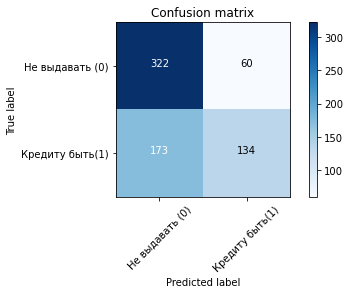

In [11]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred1_classes), ['Не выдавать (0)', 'Кредиту быть(1)'])

Вторая модель:

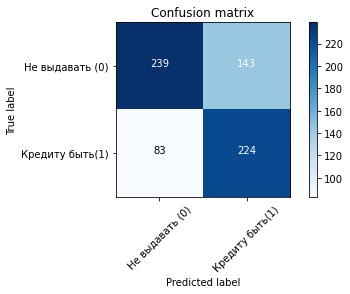

In [12]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred2_classes), ['Не выдавать (0)', 'Кредиту быть(1)'])

Третья:

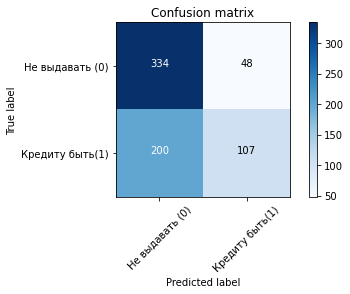

In [13]:
plot_confusion_matrix(confusion_matrix(df.target, df.pred3_classes), ['Не выдавать (0)', 'Кредиту быть(1)'])

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [14]:
def max_recall(y_true, probas, fix_accuracy=0.65):
    recall = []
    thresh = []
    for t in np.arange(0, 1.01, 0.01):
        pred_classes = np.zeros(y_true.shape[0])
        pred_classes[probas >= t] = 1
        if accuracy_score(y_true, pred_classes) >= fix_accuracy:
            thresh.append(t)
            recall.append(recall_score(y_true, pred_classes))
    try: 
        return (round(np.max(recall), 3), thresh[np.argmax(recall)])
    except: 
        return ('Not_found', 'Not_found')

print('При accuracy >= 0.65:\n') 
for i in [1, 2, 3]:
    col = f'pred{i}_probs'
    res = max_recall(df.target, df[col])
    print(f'max recall для {i}-го алгоритма равен {res[0]} (порог {res[1]})')


При accuracy >= 0.65:

max recall для 1-го алгоритма равен 0.743 (порог 0.36)
max recall для 2-го алгоритма равен 0.837 (порог 0.27)
max recall для 3-го алгоритма равен Not_found (порог Not_found)


Добиться значения accuracy 0.65 на третьем алгоритме не удается. Попробуем то же самое на уровне 0.64: 

In [15]:
print('При accuracy >= 0.64:\n') 
for i in [1, 2, 3]:
    col = f'pred{i}_probs'
    res = max_recall(df.target, df[col], fix_accuracy=0.64)
    print(f'max recall для {i}-го алгоритма равен {res[0]} (порог {res[1]})')

При accuracy >= 0.64:

max recall для 1-го алгоритма равен 0.821 (порог 0.34)
max recall для 2-го алгоритма равен 0.837 (порог 0.27)
max recall для 3-го алгоритма равен 0.642 (порог 0.23)


В любом случае максимальной полноты достигаем на втором алгоритме. Для дальнейшего выполнения заданий в 3-м алгоритме можем использовать ограничение 0.64 (чтобы матрицу нарисовать и все такое)

**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

In [16]:
def max_recall_plot(y_true, probas, thresh):
    pred_classes = np.zeros(y_true.shape[0])
    pred_classes[probas >= thresh] = 1
    plot_confusion_matrix(confusion_matrix(df.target, pred_classes), ['Не выдавать (0)', 'Кредиту быть(1)'])

**1-й  алгоритм** (0.65)

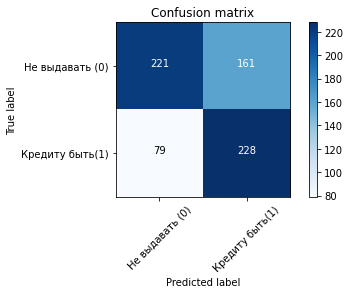

In [17]:
t1 = max_recall(df.target, df.pred1_probs)[1]
max_recall_plot(df.target, df.pred1_probs, t1)

**2-й алгоритм** (0.65)

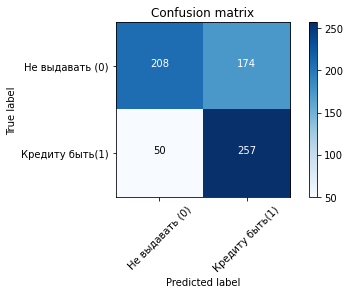

In [18]:
t2 = max_recall(df.target, df.pred2_probs)[1]
max_recall_plot(df.target, df.pred2_probs, t2)

**3-й алгоритм** (0.64)

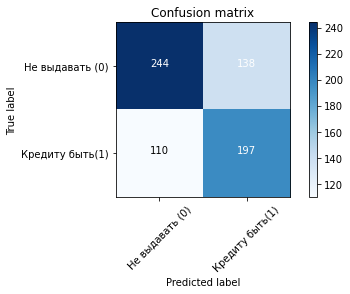

In [19]:
t3 = max_recall(df.target, df.pred3_probs, fix_accuracy=0.64)[1]
max_recall_plot(df.target, df.pred3_probs, t3)

**Выводы:** 2-я модель лучше всего справилась с поставленной задачей. 

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [20]:
def max_precision(y_true, probas, fix_accuracy=0.64):
    precision = []
    thresh = []
    for t in np.arange(0, 1.01, 0.01):
        pred_classes = np.zeros(y_true.shape[0])
        pred_classes[probas >= t] = 1
        if accuracy_score(y_true, pred_classes) >= fix_accuracy:
            thresh.append(t)
            precision.append(precision_score(y_true, pred_classes))
    return (round(np.max(precision), 3), thresh[np.argmax(precision)])

print('При accuracy >= 0.64:\n') 
for i in [1, 2, 3]:
    col = f'pred{i}_probs'
    res = max_precision(df.target, df[col], fix_accuracy=0.64)
    print(f'max precision для {i}-го алгоритма равен {res[0]} (порог {res[1]})')

При accuracy >= 0.64:

max precision для 1-го алгоритма равен 0.748 (порог 0.5700000000000001)
max precision для 2-го алгоритма равен 0.837 (порог 0.73)
max precision для 3-го алгоритма равен 0.714 (порог 0.56)


**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

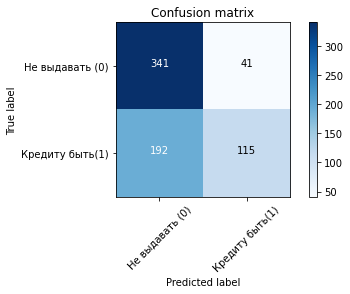

In [21]:
# first
t21 = max_precision(df.target, df.pred1_probs, fix_accuracy=0.65)[1]
max_recall_plot(df.target, df.pred1_probs, t21)

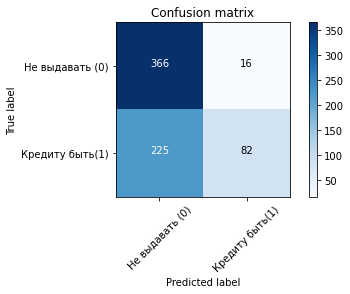

In [22]:
#second
t22 = max_precision(df.target, df.pred2_probs, fix_accuracy=0.65)[1]
max_recall_plot(df.target, df.pred2_probs, t22)

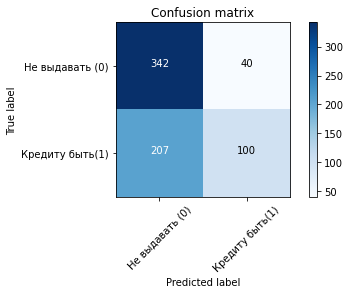

In [23]:
# third
t23 = max_precision(df.target, df.pred3_probs, fix_accuracy=0.64)[1]
max_recall_plot(df.target, df.pred3_probs, t23)

Снова с задачей лучше справляется вторая модель

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [29]:
def max_f1(y_true, probas, fix_accuracy=0.64):
    f1 = []
    thresh = []
    for t in np.arange(0, 1.01, 0.01):
        pred_classes = np.zeros(y_true.shape[0])
        pred_classes[probas >= t] = 1
        if accuracy_score(y_true, pred_classes) >= fix_accuracy:
            thresh.append(t)
            f1.append(f1_score(y_true, pred_classes))
    return (round(np.max(f1), 3), thresh[np.argmax(f1)])

print('При accuracy >= 0.64:\n') 
for i in [1, 2, 3]:
    col = f'pred{i}_probs'
    res = max_f1(df.target, df[col], fix_accuracy=0.64)
    print(f'max f1-score для {i}-го алгоритма равен {res[0]} (порог {res[1]})')

При accuracy >= 0.64:

max f1-score для 1-го алгоритма равен 0.672 (порог 0.34)
max f1-score для 2-го алгоритма равен 0.699 (порог 0.32)
max f1-score для 3-го алгоритма равен 0.614 (порог 0.23)


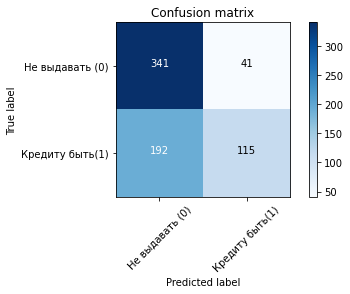

In [30]:
t31 = max_precision(df.target, df.pred1_probs, fix_accuracy=0.65)[1]
max_recall_plot(df.target, df.pred1_probs, t31)

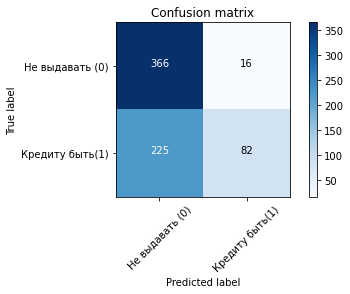

In [32]:
t32 = max_precision(df.target, df.pred2_probs, fix_accuracy=0.65)[1]
max_recall_plot(df.target, df.pred2_probs, t32)

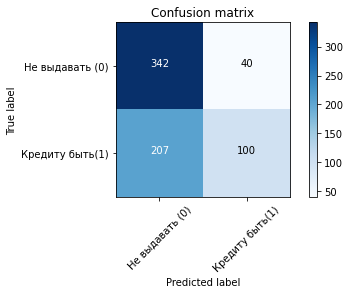

In [33]:
t33 = max_precision(df.target, df.pred3_probs, fix_accuracy=0.64)[1]
max_recall_plot(df.target, df.pred3_probs, t33)

В очередной раз лучшей для решения задачи оказывается вторая модель.

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [25]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [49]:
sc = StandardScaler()

y = df.target
X = scaler.fit_transform(df.iloc[:, :14])


lr = LogisticRegression()
lr.fit(X, y)
print(accuracy_score(y, lr.predict(X)),
f1_score(y, lr.predict(X)), sep='\n')

0.8780841799709724
0.8670886075949367


**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [57]:
#нужны вероятности
pred_probs = lr.predict_proba(X)[:, 1]
#(a) 
max_precision(y_true=y, probas=pred_probs, fix_accuracy=0)
max_recall(y, probas=pred_probs, fix_accuracy=0)
max_f1(y, pred_probs, fix_accuracy=0)

(0.869, 0.52)